In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spambase/realspambase.data


# Linear SVM

Build a linear SVM classifier to classify emails into spam and ham.

## Data Understanding

Let's first load the data and understand the attributes meanings, shape of the dataset etc.


In [2]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load the data
email_rec = pd.read_csv("../input/spambase/realspambase.data",  sep = ',', header= None )
print(email_rec.head())

     0     1     2    3     4     5     6     7     8     9   ...    48  \
0  0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.00   
1  0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.00   
2  0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.01   
3  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   
4  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   

      49   50     51     52     53     54   55    56  57  
0  0.000  0.0  0.778  0.000  0.000  3.756   61   278   1  
1  0.132  0.0  0.372  0.180  0.048  5.114  101  1028   1  
2  0.143  0.0  0.276  0.184  0.010  9.821  485  2259   1  
3  0.137  0.0  0.137  0.000  0.000  3.537   40   191   1  
4  0.135  0.0  0.135  0.000  0.000  3.537   40   191   1  

[5 rows x 58 columns]


As of now, the columns are named as integers. Let's manually name the columns appropriately (column names are available at the UCI website here: https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names)

In [4]:
# renaming the columns
email_rec.columns  = ["word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d", 
                      "word_freq_our", "word_freq_over", "word_freq_remove", "word_freq_internet", 
                      "word_freq_order", "word_freq_mail", "word_freq_receive", "word_freq_will", 
                      "word_freq_people", "word_freq_report", "word_freq_addresses", "word_freq_free", 
                      "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit", 
                      "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money", "word_freq_hp", 
                      "word_freq_hpl", "word_freq_george", "word_freq_650", "word_freq_lab", "word_freq_labs", 
                      "word_freq_telnet", "word_freq_857", "word_freq_data", "word_freq_415", "word_freq_85", 
                      "word_freq_technology", "word_freq_1999", "word_freq_parts", "word_freq_pm", "word_freq_direct",
                      "word_freq_cs", "word_freq_meeting", "word_freq_original", "word_freq_project", "word_freq_re", 
                      "word_freq_edu", "word_freq_table", "word_freq_conference", "char_freq_;", "char_freq_(", 
                      "char_freq_[", "char_freq_!", "char_freq_$", "char_freq_hash", "capital_run_length_average", 
                      "capital_run_length_longest", "capital_run_length_total", "spam"]
print(email_rec.head())

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            0.00  ...         0.00        0.000   
1 

In [5]:
# look at dimensions of the df
print(email_rec.shape)

(4601, 58)


In [6]:
# ensure that data type are correct
email_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [7]:
# there are no missing values in the dataset 
email_rec.isnull().sum()

word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_telnet              0
word_fre

Let's also look at the fraction of spam and ham emails in the dataset.

In [8]:
# look at fraction of spam emails 
# 39.4% spams
email_rec['spam'].describe()

count    4601.000000
mean        0.394045
std         0.488698
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: spam, dtype: float64

## Data Preparation

Let's now conduct some prelimininary data preparation steps, i.e. rescaling the variables, splitting into train and test etc. To understand why rescaling is required, let's print the summary stats of all columns - you'll notice that the columns at the end (capital_run_length_longest, capital_run_length_total etc.) have much higher values (means = 52, 283 etc.) than most other columns which represent fraction of word occurrences (no. of times word appears in email/total no. of words in email).


In [9]:
email_rec.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [10]:
# splitting into X and y
X = email_rec.drop("spam", axis = 1)
y = email_rec.spam.values.astype(int)

In [11]:
# scaling the features
# note that the scale function standardises each column, i.e.
# x = x-mean(x)/std(x)

from sklearn.preprocessing import scale
X = scale(X)

In [12]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

In [13]:
# confirm that splitting also has similar distribution of spam and ham 
# emails
print(y_train.mean())
print(y_test.mean())

0.3978260869565217
0.38522809558291093


## Model Building

Let's build a linear SVM mode now. The ```SVC()``` class does that in sklearn. We highly recommend reading the documentation at least once.


In [14]:
# Model building

# instantiate an object of class SVC()
# note that we are using cost C=1
model = SVC(C = 1)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

In [15]:
# Evaluate the model using confusion matrix 
from sklearn import metrics
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[811,  38],
       [ 61, 471]])

In [16]:
# print other metrics

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred))


accuracy 0.9283128167994207
precision 0.925343811394892
recall 0.8853383458646616


In [17]:
# specificity (% of hams correctly classified)
print("specificity", 811/(811+38))

specificity 0.9552414605418139


The SVM we have built so far gives decently good results - an accuracy of 92%, sensitivity/recall (TNR) of 88%. 

### Interpretation of Results

In the confusion matrix, the elements at (0, 0) and (1,1) correspond to the more frequently occurring class, i.e. ham emails. Thus, it implies that:
- 92% of all emails are classified correctly
- 88.5% of spams are identified correctly (sensitivity/recall)
- Specificity, or % of hams classified correctly, is 95%



## Hyperparameter Tuning

### K-Fold Cross Validation

Let's first run a simple k-fold cross validation to get a sense of the **average metrics** as computed over multiple *folds*. the easiest way to do cross-validation is to use the ```cross_val_score()``` function.



In [18]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# instantiating a model with cost=1
model = SVC(C = 1)

In [19]:
# computing the cross-validation scores 
# note that the argument cv takes the 'folds' object, and
# we have specified 'accuracy' as the metric

cv_results = cross_val_score(model, X_train, y_train, cv = folds, scoring = 'accuracy') 

In [20]:
# print 5 accuracies obtained from the 5 folds
print(cv_results)
print("mean accuracy = {}".format(cv_results.mean()))

[0.91770186 0.94099379 0.92080745 0.93012422 0.93944099]
mean accuracy = 0.9298136645962731


## Grid Search to Find Optimal Hyperparameter C

K-fold CV helps us compute average metrics over multiple folds, and that is the best indication of the 'test accuracy/other metric scores' we can have. 

But we want to use CV to compute the optimal values of hyperparameters (in this case, the cost C is a hyperparameter). This is done using the ```GridSearchCV()``` method, which computes metrics (such as accuracy, recall etc.) 

In this case, we have only one hyperparameter, though you can have multiple, such as C and gamma in non-linear SVMs. In that case, you need to search through a *grid* of multiple values of C and gamma to find the optimal combination, and hence the name GridSearchCV.

In [21]:
# specify range of parameters (C) as a list
params = {"C": [0.1, 1, 10, 100, 1000]}

model = SVC()

# set up grid search scheme
# note that we are still using the 5 fold CV scheme we set up earlier
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                       return_train_score=True)      

In [22]:
# fit the model - it will fit 5 folds across all values of C
model_cv.fit(X_train, y_train)  

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   14.0s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=SVC(), param_grid={'C': [0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [23]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.428596,0.005226,0.084937,0.002445,0.1,{'C': 0.1},0.895963,0.902174,0.906832,0.902174,...,0.905280,0.007795,5,0.912655,0.911879,0.912267,0.911102,0.906056,0.910792,0.002423
1,0.288586,0.009971,0.053170,0.002648,1,{'C': 1},0.917702,0.940994,0.920807,0.930124,...,0.929814,0.009440,2,0.951475,0.946040,0.949922,0.946040,0.945652,0.947826,0.002401
2,0.246989,0.010275,0.041036,0.001621,10,{'C': 10},0.908385,0.944099,0.933230,0.928571,...,0.930745,0.012368,1,0.975543,0.970885,0.973991,0.968944,0.971273,0.972127,0.002347
3,0.265274,0.015770,0.036839,0.001905,100,{'C': 100},0.913043,0.927019,0.936335,0.930124,...,0.928571,0.008562,3,0.989519,0.989907,0.989907,0.988354,0.987966,0.989130,0.000814
4,0.329601,0.038915,0.034055,0.003134,1000,{'C': 1000},0.908385,0.931677,0.922360,0.919255,...,0.920497,0.007440,4,0.996118,0.993789,0.994177,0.993789,0.994177,0.994410,0.000872


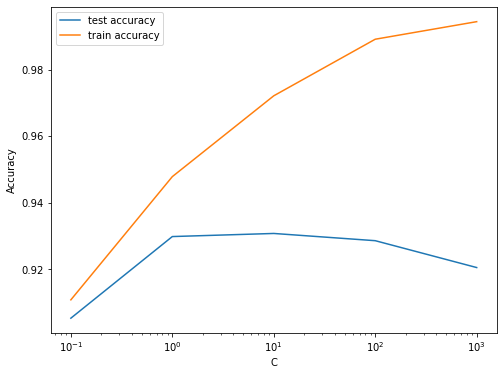

In [24]:
# plot of C versus train and test scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

Though the training accuracy monotonically increases with C, the test accuracy gradually reduces. Thus, we can conclude that higher values of C tend to **overfit** the model. This is because a high C value aims to classify all training examples correctly (since C is the *cost of misclassification* - if you impose a high cost on the model, it will avoid misclassifying any points by overfitting the data). 



Let's finally look at the optimal C values found by GridSearchCV.

In [25]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test accuracy is {0} at C = {1}".format(best_score, best_C))

 The highest test accuracy is 0.9307453416149067 at C = 10


Let's now look at the metrics corresponding to C=10.

In [26]:
# model with the best value of C
model = SVC(C=best_C)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

In [27]:
# metrics
# print other metrics

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred))


accuracy 0.9304851556842868
precision 0.9241245136186771
recall 0.8928571428571429


## Optimising for Other Evaluation Metrics

In this case, we had optimised (tuned) the model based on overall accuracy, though that may not always be the best metric to optimise. For example, if you are concerned more about catching all spams (positives), you may want to maximise TPR or sensitivity/recall. If, on the other hand, you want to avoid classifying hams as spams (so that any important mails don't get into the spam box), you would maximise the TNR or specificity.

In [28]:
# specify params
params = {"C": [0.1, 1, 10, 100, 1000]}

# specify scores/metrics in an iterable
scores = ['accuracy', 'precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for {}".format(score))
    
    # set up GridSearch for score metric
    clf = GridSearchCV(SVC(), 
                       params, 
                       cv=folds,
                       scoring=score,
                       return_train_score=True)
    # fit
    clf.fit(X_train, y_train)

    print(" The highest {0} score is {1} at C = {2}".format(score, clf.best_score_, clf.best_params_))
    print("\n")

# Tuning hyper-parameters for accuracy
 The highest accuracy score is 0.9307453416149067 at C = {'C': 10}


# Tuning hyper-parameters for precision
 The highest precision score is 0.9373311086391073 at C = {'C': 0.1}


# Tuning hyper-parameters for recall
 The highest recall score is 0.8987270122310326 at C = {'C': 10}




# Non-Linear SVM

A non-linear model (using non-linear kernels) and then finding the optimal hyperparameters (the choice of kernel, C, gamma).

In [29]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

In [30]:
email_rec = pd.read_csv("../input/spambase/realspambase.data",  sep = ',', header= None )
email_rec.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Renaming the column names

In [31]:
# renaming the columns
email_rec.columns  = ["word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d", 
                      "word_freq_our", "word_freq_over", "word_freq_remove", "word_freq_internet", 
                      "word_freq_order", "word_freq_mail", "word_freq_receive", "word_freq_will", 
                      "word_freq_people", "word_freq_report", "word_freq_addresses", "word_freq_free", 
                      "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit", 
                      "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money", "word_freq_hp", 
                      "word_freq_hpl", "word_freq_george", "word_freq_650", "word_freq_lab", "word_freq_labs", 
                      "word_freq_telnet", "word_freq_857", "word_freq_data", "word_freq_415", "word_freq_85", 
                      "word_freq_technology", "word_freq_1999", "word_freq_parts", "word_freq_pm", "word_freq_direct",
                      "word_freq_cs", "word_freq_meeting", "word_freq_original", "word_freq_project", "word_freq_re", 
                      "word_freq_edu", "word_freq_table", "word_freq_conference", "char_freq_;", "char_freq_(", 
                      "char_freq_[", "char_freq_!", "char_freq_$", "char_freq_hash", "capital_run_length_average", 
                      "capital_run_length_longest", "capital_run_length_total", "spam"]
print(email_rec.head())

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            0.00  ...         0.00        0.000   
1 

## Data Preparation

In [32]:
# splitting into X and y
X = email_rec.drop("spam", axis = 1)
y = email_rec.spam.values.astype(int)

In [33]:
# scaling the features
X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 4)

## Model Building

In [34]:
# using rbf kernel, C=1, default value of gamma

model = SVC(C = 1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Model Evaluation Metrics

In [35]:
# confusion matrix
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[811,  38],
       [ 61, 471]])

In [36]:
# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred))

accuracy 0.9283128167994207
precision 0.925343811394892
recall 0.8853383458646616


## Hyperparameter Tuning 

Now, we have multiple hyperparameters to optimise - 
- The choice of kernel (linear, rbf etc.)
- C
- gamma

We'll use the ```GridSearchCV()``` method to tune the hyperparameters. 

## Grid Search to Find Optimal Hyperparameters

Let's first use the RBF kernel to find the optimal C and gamma (we can consider the kernel as a hyperparameter as well, though training the model will take an exorbitant amount of time). 

In [37]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   33.9s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [38]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.269214,0.020033,0.055881,0.006710,1,0.01,"{'C': 1, 'gamma': 0.01}",0.917702,0.939441,0.922360,...,0.929814,0.008528,5,0.943323,0.940994,0.945264,0.937112,0.939829,0.941304,0.002814
1,0.366548,0.013515,0.075167,0.003104,1,0.001,"{'C': 1, 'gamma': 0.001}",0.886646,0.919255,0.899068,...,0.904037,0.013080,10,0.910326,0.903339,0.908773,0.906056,0.904115,0.906522,0.002672
2,0.593977,0.011529,0.123664,0.001715,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.770186,0.802795,0.791925,...,0.786025,0.015322,12,0.789208,0.779503,0.785326,0.791925,0.788820,0.786957,0.004277
3,0.219823,0.020667,0.037520,0.002060,10,0.01,"{'C': 10, 'gamma': 0.01}",0.909938,0.944099,0.934783,...,0.933230,0.012266,3,0.966227,0.966615,0.967003,0.961568,0.962345,0.964752,0.002308
4,0.249746,0.020745,0.046656,0.003762,10,0.001,"{'C': 10, 'gamma': 0.001}",0.917702,0.934783,0.916149,...,0.928261,0.009491,7,0.937112,0.932453,0.936335,0.935171,0.931289,0.934472,0.002242
5,0.359926,0.003320,0.072597,0.001754,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.883540,0.914596,0.899068,...,0.902174,0.013749,11,0.909938,0.902174,0.908773,0.905280,0.902562,0.905745,0.003158
6,0.245291,0.018731,0.033737,0.003829,100,0.01,"{'C': 100, 'gamma': 0.01}",0.913043,0.937888,0.934783,...,0.931677,0.010159,4,0.982531,0.979814,0.982531,0.982143,0.982531,0.981910,0.001059
7,0.225962,0.006616,0.035665,0.002324,100,0.001,"{'C': 100, 'gamma': 0.001}",0.923913,0.940994,0.925466,...,0.933851,0.008482,1,0.950311,0.949534,0.948758,0.945652,0.939829,0.946817,0.003835
8,0.247058,0.005592,0.045038,0.000681,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.919255,0.934783,0.917702,...,0.927019,0.007349,8,0.934006,0.931289,0.934006,0.930901,0.929348,0.931910,0.001831
9,0.348134,0.028022,0.030787,0.003059,1000,0.01,"{'C': 1000, 'gamma': 0.01}",0.908385,0.922360,0.920807,...,0.918323,0.005607,9,0.993789,0.992624,0.992624,0.993012,0.992236,0.992857,0.000527


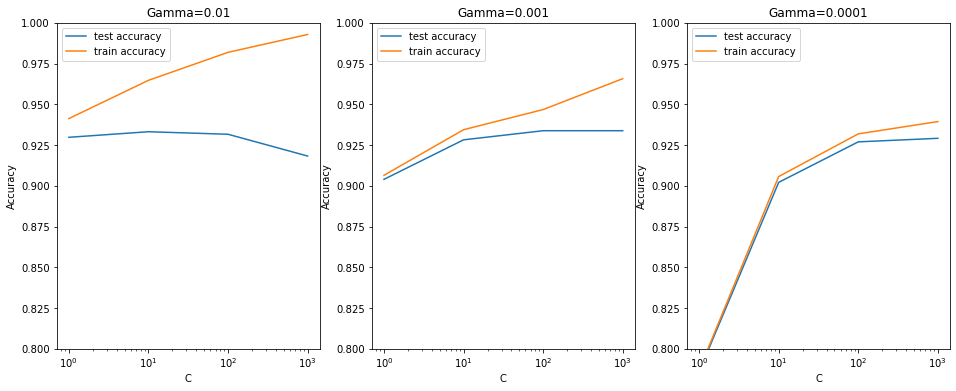

In [39]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


This plot reveals some interesting insights:
- **High values of gamma** lead to **overfitting** (especially at high values of C); note that the training accuracy at gamma=0.01 and C=1000 reaches almost 99% 
- The **training score increases with higher gamma**, though the **test scores are comparable** (at sufficiently high cost, i.e. C > 10)
- The least amount of overfitting (i.e. difference between train and test accuracy) occurs at low gamma, i.e. a quite *simple non-linear model*


In [40]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9338509316770185 corresponding to hyperparameters {'C': 100, 'gamma': 0.001}


Though sklearn suggests the optimal scores mentioned above (gamma=0.001, C=100), one could argue that it is better to choose a simpler, more non-linear model with gamma=0.0001. This is because the optimal values mentioned here are calculated based on the average test accuracy (but not considering subjective parameters such as model complexity).

We can achieve comparable average test accuracy (~92.5%) with gamma=0.0001 as well, though we'll have to increase the cost C for that. So to achieve high accuracy, there's a tradeoff between:
- High gamma (i.e. high non-linearity) and average value of C
- Low gamma (i.e. less non-linearity) and high value of C

We argue that the model will be simpler if it has as less non-linearity as possible, so we choose gamma=0.0001 and a high C=100.

### Building and Evaluating the Final Model

Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [41]:
# specify optimal hyperparameters
best_params = {"C": 100, "gamma": 0.0001, "kernel":"rbf"}

# model
model = SVC(C=100, gamma=0.0001, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print(metrics.confusion_matrix(y_test, y_pred), "\n")
print("accuracy", metrics.accuracy_score(y_test, y_pred))
print("precision", metrics.precision_score(y_test, y_pred))
print("sensitivity/recall", metrics.recall_score(y_test, y_pred))

[[810  39]
 [ 60 472]] 

accuracy 0.9283128167994207
precision 0.923679060665362
sensitivity/recall 0.8872180451127819


## Conclusion

The accuracy achieved using a non-linear kernel is comparable to that of a linear one. Thus, it turns out that for this problem, **you do not really need a non-linear kernel**.